# Building application + model serving pipeline

In [1]:
import mlrun

## Creating project

In [2]:
project = mlrun.get_or_create_project('huggingface', context='./')

> 2023-01-24 12:47:44,295 [info] loaded project huggingface from MLRun DB


## Building a serving function

The serving function is consisted of preprocess functions that transfers the text input into a request for the serving function, and the postprocess function passes the model output into the gradio interface. 

See the functions in [here](./src/serving.py)

In [3]:
serving_function = mlrun.code_to_function(
    filename="src/serving.py",
    name="hugging-face-serving",
    kind="serving", 
    image="yonishelach/ml-models:huggingface-demo-3",
)

## Defining our serving graph

Setting the serving graph topology with the step order

In [4]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

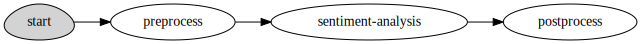

In [5]:
# Build the serving graph:
graph.to(handler="preprocess", name="preprocess")\
     .to("mlrun.frameworks.huggingface.HuggingFaceModelServer",
          name="sentiment-analysis",
          task="sentiment-analysis",
          model_name="distilbert-base-uncased",
          model_class="AutoModelForSequenceClassification",
          tokenizer_name="distilbert-base-uncased",
          tokenizer_class="AutoTokenizer")\
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
graph.plot(rankdir='LR')

In [6]:
# registering the serving 
project.set_function(serving_function)
project.save()

## Simulate the application pipeline locally

Creating a mocking server for testing

In [7]:
server = serving_function.to_mock_server()

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

> 2023-01-24 12:48:19,372 [info] model sentiment-analysis was loaded


## Testing the model

In [8]:
response = server.test(path='/predict', body= "i love flying")

In [9]:
response

['The sentiment is POSITIVE', 'The prediction score is 0.531823992729187']

## Deploy

In [10]:
serving_fn = project.deploy_function(serving_function)

> 2023-01-24 12:48:40,260 [info] Starting remote function deploy
2023-01-24 12:48:40  (info) Deploying function
2023-01-24 12:48:40  (info) Building
2023-01-24 12:48:40  (info) Staging files and preparing base images
2023-01-24 12:48:40  (info) Building processor image
2023-01-24 12:52:40  (info) Build complete
2023-01-24 12:54:30  (info) Function deploy complete
> 2023-01-24 12:54:31,558 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-huggingface-hugging-face-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['huggingface-hugging-face-serving-huggingface.default-tenant.app.cto-office.iguazio-cd1.com/']}


## Gradio front-end

Gradio is a friendly web interface that we demonstrate here how to use easily for submitting predictions to our real-time pipeline and to get the results as well!

For more information, please see [gradio page](https://gradio.app/)

In [13]:
!pip install gradio

     |████████████████████████████████| 14.2 MB 24.1 MB/s eta 0:00:01
     |████████████████████████████████| 812 kB 106.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 98.3 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 89.0 MB/s eta 0:00:01
     |████████████████████████████████| 106 kB 115.0 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 88.5 MB/s  eta 0:00:01
     |████████████████████████████████| 71 kB 90.5 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 73.3 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 85.0 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 98.8 MB/s  eta 0:00:01
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31669 sha256=01373234630eca75163ed7f24f5da577c658601a0fc2f4189dfafc8799214290
  Stored in directory: /tmp/pip-ephem-wheel-cache-lztxj_m4/wheels/2c/41/7c/bfd1c180534ffdcc0972f78c5758f89881602175d48a8bcd2c
  Created wheel

In [14]:
serving_url = serving_fn.outputs['endpoint']

In [15]:
import gradio as gr
import requests

In [16]:
def sentiment(text):
    resp = requests.post(serving_url, json={"text": text})
    return resp.json()


with gr.Blocks() as demo:
    input_box = [gr.Textbox(label="Text to analyze", placeholder="Please insert text")]
    output = [gr.Textbox(label="Sentiment analysis result"), gr.Textbox(label="Sentiment analysis score")]
    greet_btn = gr.Button("Submit")
    greet_btn.click(fn=sentiment, inputs=input_box, outputs=output)

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://2a3a3371-eccf-42e5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [17]:
x = project.get_function("hugging-face-serving")

In [18]:
x.status.address

'huggingface-hugging-face-serving-huggingface.default-tenant.app.cto-office.iguazio-cd1.com/'

In [19]:
serving_url

'http://huggingface-hugging-face-serving-huggingface.default-tenant.app.cto-office.iguazio-cd1.com/'

In [20]:
x.spec.command

'http://huggingface-hugging-face-serving-huggingface.default-tenant.app.cto-office.iguazio-cd1.com/'

In [21]:
x.to_dict()

{'kind': 'serving',
 'metadata': {'name': 'hugging-face-serving',
  'tag': '',
  'project': 'huggingface',
  'credentials': {'access_key': '$ref:mlrun-auth-secrets.ecd3782fa9ddbde24e79bb4ec95a9b3da65a95f565287f2a799e12c4'}},
 'spec': {'command': 'http://huggingface-hugging-face-serving-huggingface.default-tenant.app.cto-office.iguazio-cd1.com/',
  'args': [],
  'image': 'yonishelach/ml-models:huggingface-demo-3',
  'build': {'functionSourceCode': 'aW1wb3J0IG1scnVuCmZyb20gdHlwaW5nIGltcG9ydCBEaWN0LCBVbmlvbiwgTGlzdAoKTEFCRUxTID0gewogICAgIkxBQkVMXzAiOiAiTkVHQVRJVkUiLAogICAgIkxBQkVMXzEiOiAiUE9TSVRJVkUiCn0KZGVmIHByZXByb2Nlc3ModGV4dDogVW5pb25bc3RyLCBieXRlc10pIC0+IERpY3Q6CiAgICAiIiJDb252ZXJ0aW5nIGEgc2ltcGxlIHRleHQgaW50byBhIHN0cnVjdHVyZWQgYm9keSBmb3IgdGhlIHNlcnZpbmcgZnVuY3Rpb24KICAgIAogICAgOnBhcmFtIHRleHQ6IFRoZSB0ZXh0IHRvIHByZWRpY3QKICAgICIiIgogICAgcmV0dXJuIHsiaW5wdXRzIjogW3N0cih0ZXh0KV19CgoKZGVmIHBvc3Rwcm9jZXNzKG1vZGVsX3Jlc3BvbnNlOiBEaWN0KSAtPiBMaXN0OgogICAgIiIiVHJhbnNmZXJpbmcgdGhlIHByZWRpY3Rp